In [ ]:
!pip install transformers
!pip install datasets 
!pip install pandas
!pip install evaluate 
!pip install accelerate
!pip install numpy
!pip install sklearn
!pip install openpyxl

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import transformers
import datasets
import pandas as pd
import evaluate
import accelerate
import numpy as np
import sklearn
import openpyxl

from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from transformers import BertTokenizer, BertForMaskedLM, AutoTokenizer, AutoModel, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures, DataCollatorWithPadding

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from transformers import AdamW
from transformers import get_scheduler
from accelerate import Accelerator
from tqdm.auto import tqdm
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torch.nn.init as init
from torch import argmax
from torch import no_grad


In [ ]:
dataset = load_dataset('climate_fever')  #loading the dataset

#------------------making a new row for every claim-evidence pair-----------------------
def extract_str(dict_):
    x = []
    y = []
    z = []
    for i in dict_["evidences"]:
        x.append(i['evidence'])
        y.append(i['evidence_label'])
        z.append(i['votes'])
    dict_["evidences_text"] = x
    dict_["evidences_label"] = y
    dict_["evidences_vote"] = z
       
    return dict_

df_evid = dataset.map(extract_str)

df = pd.DataFrame.from_dict(df_evid['test']).loc[:,['claim','evidences_text','evidences_label',]]

df_expl = df.explode('evidences_text', ignore_index = True)

df_final = df.apply(pd.Series.explode).reset_index().drop(['index'], axis=1)
df_final['idx'] = range(1, len(df_final) + 1)
df_final = df_final.rename(columns={"evidences_label": "labels"}, errors="raise")

df_final = df_final[df_final['labels']!=2]   #Using only labels 1 & 2  (i.e. those evidence sentences that either support/refute a claim)

In [ ]:
#setting training and validation split
train, val = train_test_split(df_final, test_size=0.1)

train_final = datasets.Dataset.from_dict(train)
val_final = datasets.Dataset.from_dict(val)

dataset_dict = datasets.DatasetDict({"train":train_final,"validation":val_final, })
dataset_dict

In [ ]:
#Choosing and downloading the model
distil_roberta = "distilroberta-base" #this on is case sensitive
climatebert = "climatebert/distilroberta-base-climate-f"

model_name = distil_roberta   #climatebert
labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = labels) # problem_type="multi_label_classification")


#Tokenizing the dataset
def tokenize_function(example):
    return tokenizer(example["claim"], example["evidences_text"], truncation=True, max_length = 512,padding='max_length')

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



tokenized_datasets = tokenized_datasets.remove_columns(["claim", "evidences_text", "idx"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


In [ ]:
#Setting the batch size 
batch_size = 32

#using dataloader to prepare traing and validation datasets
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
# setting up lists for handling loss/accuracy
train_accuracies, eval_accuracies = [],[]
train_losses, eval_losses = [],[]

train_targs, train_preds = [], []
eval_targs, eval_preds = [],[]

f1_eval_all, f1_train_all  = [], []
#roc_auc_train_all, roc_auc_eval_all= [], []

### Initializing model and optimizer
accelerator = Accelerator()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
optimizer = AdamW(model.parameters(), 
                lr=5e-5, weight_decay=0.01)

### Preparing training and evaluation datasets 
train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

# Setting the scheduler
num_epochs = 100
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

In [ ]:
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    
    #----------------### The training loop ####---------------
    model.train()
    cur_train_targs, cur_train_preds = [],[]
    train_loss = 0
    
    for batch in train_dl:
        outputs = model(**batch)
        
        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_train_targs += batch["labels"].tolist() 
        cur_train_preds += predictions.tolist()    
        
        #Losses
        loss = outputs.loss
        accelerator.backward(loss)
        train_loss += loss 
        #Optimizer step
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    
    #----------------### The evaluation loop ####---------------
    model.eval()
    cur_eval_targs, cur_eval_preds = [],[]
    eval_loss = 0
    metric = evaluate.load("glue", "mrpc")

    for batch in eval_dl:
        with no_grad():
            outputs = model(**batch)

        #Predictions
        logits = outputs.logits
        predictions = argmax(logits, dim=-1)
        
        cur_eval_targs += batch["labels"].tolist()      
        cur_eval_preds += predictions.tolist()         
        
        #Losses
        eval_loss += outputs.loss 
        metric.add_batch(predictions=predictions, references=batch["labels"])

    #---- Taking note of the losses and accuracies #--#
    train_losses.append(train_loss.tolist() / len(train_dl))  # the training loss
    eval_losses.append(eval_loss.tolist() / len(eval_dl))    # the validation loss

    train_acc_cur = accuracy_score(cur_train_targs, cur_train_preds)    
    train_accuracies.append(train_acc_cur)
    
    eval_acc_cur = accuracy_score(cur_eval_targs, cur_eval_preds)    
    eval_accuracies.append(eval_acc_cur)
    
    f1_train = f1_score(cur_train_targs, cur_train_preds, average='weighted')
    f1_eval = f1_score(cur_eval_targs, cur_eval_preds, average='weighted')
    f1_train_all.append(f1_train)
    f1_eval_all.append(f1_eval)

    #----------- Keeping track of the actual predictions and targets #---------#
    eval_targs += cur_eval_targs
    eval_preds += cur_eval_preds
      
    train_targs += cur_train_targs
    train_preds += cur_train_preds
    #------------------------------------------------------------------------------#

    #Saving results to drive
    pd.DataFrame(eval_targs).to_excel('/content/gdrive/MyDrive/DL_distilroberta/last_eval_targs.xlsx')
    pd.DataFrame(eval_preds).to_excel('/content/gdrive/MyDrive/DL_distilroberta/last_eval_preds.xlsx')
    pd.DataFrame(train_targs).to_excel('/content/gdrive/MyDrive/DL_distilroberta/last_train_targs.xlsx')
    pd.DataFrame(train_preds).to_excel('/content/gdrive/MyDrive/DL_distilroberta/last_train_preds.xlsx')
    pd.DataFrame(train_losses).to_excel('/content/gdrive/MyDrive/DL_distilroberta/train_losses.xlsx')
    pd.DataFrame(eval_losses).to_excel('/content/gdrive/MyDrive/DL_distilroberta/eval_losses.xlsx')
    pd.DataFrame(train_accuracies).to_excel('/content/gdrive/MyDrive/DL_distilroberta/train_accuracies.xlsx')
    pd.DataFrame(eval_accuracies).to_excel('/content/gdrive/MyDrive/DL_distilroberta/eval_accuracies.xlsx')
    pd.DataFrame(f1_train_all).to_excel('/content/gdrive/MyDrive/DL_distilroberta/f1_train_all.xlsx')
    pd.DataFrame(f1_eval_all).to_excel('/content/gdrive/MyDrive/DL_distilroberta/f1_eval_all.xlsx')


  1%|          | 78/7800 [01:53<2:17:46,  1.07s/it]

 95%|█████████▌| 7410/7800 [3:31:47<06:58,  1.07s/it]

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sn 

import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
last_eval_targs = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/last_eval_targs.xlsx')
last_eval_preds = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/last_eval_preds.xlsx')
last_train_targs = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/last_train_targs.xlsx')
last_train_preds= pd.read_excel('/content/drive/MyDrive/DL_distilroberta/last_train_preds.xlsx') 

In [ ]:
train_losses = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/train_losses.xlsx')
eval_losses= pd.read_excel('/content/drive/MyDrive/DL_distilroberta/eval_losses.xlsx')
train_accuracies = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/train_accuracies.xlsx')
eval_accuracies = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/eval_accuracies.xlsx')
f1_train_all = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/f1_train_all.xlsx')
f1_eval_all = pd.read_excel('/content/drive/MyDrive/DL_distilroberta/f1_eval_all.xlsx')

In [ ]:
#Computing statistics 

avg_loss_train = np.mean(train_losses)
avg_loss_eval = np.mean(eval_losses)

avg_accur_train = np.mean(train_accuracies)
avg_accur_eval = np.mean(eval_accuracies)

avg_f1_train = np.mean(f1_train_all)
avg_f1_eval = np.mean(f1_eval_all)

best_loss_train = np.min(train_losses)
best_loss_eval = np.min(eval_losses)

best_accur_train = np.max(train_accuracies)
best_accur_eval = np.max(eval_accuracies)

best_f1_train = np.max(f1_train_all)
best_f1_eval = np.max(f1_eval_all)

In [ ]:
#saving statistics
with open('/content/drive/MyDrive/DL_distilroberta/Resultater_distilroberta.txt','w') as file:
    file.write('avg_loss_train: ' + str(avg_loss_train))
    file.write('\n')
    file.write('avg_loss_eval: ' + str(avg_loss_eval))
    file.write('\n')
    file.write('avg_accur_train: ' + str(avg_accur_train))
    file.write('\n')
    file.write('avg_accur_eval: ' + str(avg_accur_eval))
    file.write('\n')
    file.write('avg_f1_train: ' + str(avg_f1_train))
    file.write('\n')
    file.write('avg_f1_eval: ' + str(avg_f1_eval))
    file.write('\n')
    file.write('best_loss_train: ' + str(best_loss_train))
    file.write('\n')
    file.write('best_loss_eval: ' + str(best_loss_eval))
    file.write('\n')
    file.write('best_accur_train: ' + str(best_accur_train))
    file.write('\n')
    file.write('best_accur_eval: ' + str(best_accur_eval))
    file.write('\n')
    file.write('best_f1_train: ' + str(best_f1_train))
    file.write('\n')
    file.write('best_f1_eval: ' + str(best_f1_eval))

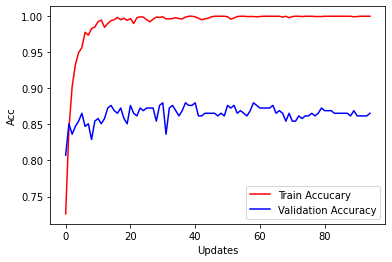

In [ ]:
# plotting losses, accuracies, f1 and confusion matrix
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, train_accuracies.iloc[:,-1], 'r', epoch, eval_accuracies.iloc[:,-1], 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
fig_scores.savefig('/content/drive/MyDrive/DL_distilroberta/Accuracies_fc_distilroberta.png')

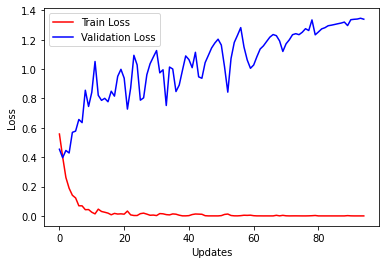

In [ ]:
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, train_losses.iloc[:,-1], 'r', epoch, eval_losses.iloc[:,-1], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
fig_scores.savefig('/content/drive/MyDrive/DL_distilroberta/Losses_fc_distilroberta.png')

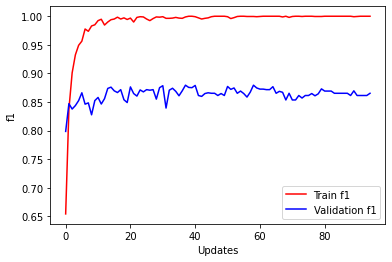

In [ ]:
epoch = np.arange(len(train_accuracies))
fig_scores = plt.figure()
plt.plot(epoch, f1_train_all.iloc[:,-1], 'r', epoch, f1_eval_all.iloc[:,-1], 'b')
plt.legend(['Train f1','Validation f1'])
plt.xlabel('Updates'), plt.ylabel('f1')
fig_scores.savefig('/content/drive/MyDrive/DL_distilroberta/f1_fc_distilroberta.png')

In [ ]:
numpypreds = np.array(last_eval_preds.iloc[-298:,-1])
numpypreds = np.where(numpypreds == 0, 'Supports', np.where(numpypreds == 1, 'Refutes', 'Else'))

numpylabels = np.array(last_eval_targs.iloc[-298:,-1])
numpylabels = np.where(numpylabels == 0, 'Supports', np.where(numpylabels == 1, 'Refutes', 'Else'))

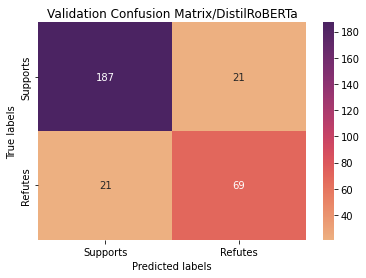

In [ ]:
confmatrix = confusion_matrix(numpylabels, numpypreds, labels = ['Supports', 'Refutes'], sample_weight=None, normalize=None)
fig = plt.figure()
ax = fig.add_subplot()
sn.heatmap(confmatrix, annot=True, cmap = 'flare',fmt='d', ax=ax, cbar=True);  #an,not=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels'); 
ax.set_ylabel('True labels'); 
ax.set_title('Validation Confusion Matrix'+str('/')+'DistilRoBERTa'); 
ax.xaxis.set_ticklabels(['Supports', 'Refutes']); ax.yaxis.set_ticklabels(['Supports', 'Refutes']);
fig.savefig('/content/drive/MyDrive/DL_distilroberta/confmatrix_distilroberta.png')